In [1]:
import numpy as np
import xarray as xr
import stmat
import geopandas as gpd
import shapely as sp

Initialize raster coordinate information:

In [2]:
minx = 5 
maxx = 10
miny = 50
maxy = 55
dx = 0.5 #Resolution in x
dy = 0.5 #Resolution in y

nx = (maxx - minx)/dx
ny = (maxy - miny)/dy

Create synthetic data 

In [3]:
n_points = 10000
n_time = 1

synthetic h2ph data

In [4]:
stack = np.empty((n_points,0))

for i in range(1):
    slc= np.random.random((100,100))
    stack = np.append(stack, slc[0:100,0:100].reshape(n_points,1), axis=1)

stack = np.array(stack*10, dtype='int')
print(stack.shape)


(10000, 1)


Case 1: synthetic coords (sorted in x and y)

In [5]:
x = np.sort(np.random.random(100)*(maxx - minx) + minx)
y = np.sort(np.random.random(100)*(maxy - miny) + miny)

In [6]:
xx, yy = np.meshgrid(x,y)
xxreshape = xx.reshape(n_points,1)
yyreshape = yy.reshape(n_points,1)

In [7]:
stack_xx = np.empty((n_points,0))
stack_yy = np.empty((n_points,0))

for i in range(1):
    stack_xx = np.append(stack_xx, xxreshape, axis=1)
    stack_yy = np.append(stack_yy, yyreshape, axis=1)


Create Xarray object with coordinates as variables

In [8]:
data_xr = xr.Dataset(data_vars=dict(h2ph=(["points", "time"], stack), xv=(["points","time"],stack_xx),yv=(["points","time"],stack_yy),),
                     coords=dict(
                        points=np.arange(n_points),
                        time=np.arange(n_time),
                        ))

data_xr

<xarray.Dataset>
Dimensions:  (points: 10000, time: 1)
Coordinates:
  * points   (points) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * time     (time) int64 0
Data variables:
    h2ph     (points, time) int64 9 5 1 6 2 0 4 1 9 7 6 ... 2 9 9 4 7 7 7 8 6 2
    xv       (points, time) float64 5.026 5.059 5.069 ... 9.895 9.965 9.997
    yv       (points, time) float64 50.01 50.01 50.01 ... 54.95 54.95 54.95

Import rasterio and related module for rasterize

In [9]:
import rasterio
from rasterio import features
from rasterio import enums
import affine
import matplotlib.pyplot as plt

Convert xarray to geopandas data-frame for use in rasterize

In [10]:
df = data_xr.to_dataframe().reset_index()

gdf = gpd.GeoDataFrame(
    df.h2ph, geometry=gpd.points_from_xy(df.xv,df.yv))

gdf.sort_values('h2ph')

,h2ph,geometry
5403,0,POINT (5.07308 52.96622)
1463,0,POINT (7.96274 50.97849)
5103,0,POINT (5.07308 52.75923)
5106,0,POINT (5.17342 52.75923)
1455,0,POINT (7.09652 50.97849)
...,...,...
4809,9,POINT (5.50511 52.63023)
4818,9,POINT (5.78512 52.63023)
4837,9,POINT (6.69801 52.63023)
4842,9,POINT (6.88150 52.63023)


Convert point-set to raster using rasterize with point index as value

In [11]:
grid_cell  = ((shapes) for shapes in zip(gdf.geometry, gdf.index))
raster = rasterio.features.rasterize(shapes=grid_cell, out_shape =[10,10], fill=np.NAN, all_touched= True, default_value=1, transform=affine.Affine.from_gdal(5.0, 0.5, 0.0, 54.9, 0.0, -0.5)) #, merge_alg= MergeAlg.replace
print (raster)

[[9708. 9724. 9731. 9748. 9756. 9763. 9777. 9787. 9789. 9799.]
 [8908. 8924. 8931. 8948. 8956. 8963. 8977. 8987. 8989. 8999.]
 [7908. 7924. 7931. 7948. 7956. 7963. 7977. 7987. 7989. 7999.]
 [6708. 6724. 6731. 6748. 6756. 6763. 6777. 6787. 6789. 6799.]
 [5208. 5224. 5231. 5248. 5256. 5263. 5277. 5287. 5289. 5299.]
 [4108. 4124. 4131. 4148. 4156. 4163. 4177. 4187. 4189. 4199.]
 [3208. 3224. 3231. 3248. 3256. 3263. 3277. 3287. 3289. 3299.]
 [2008. 2024. 2031. 2048. 2056. 2063. 2077. 2087. 2089. 2099.]
 [1308. 1324. 1331. 1348. 1356. 1363. 1377. 1387. 1389. 1399.]
 [ 708.  724.  731.  748.  756.  763.  777.  787.  789.  799.]]


Visualize results

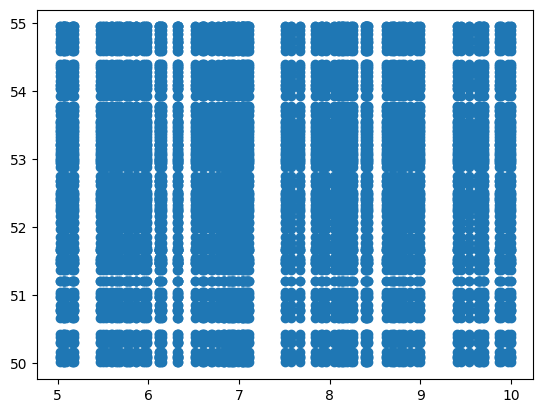

In [12]:
plt.scatter(data_xr.xv, data_xr.yv) #Original complete data-set

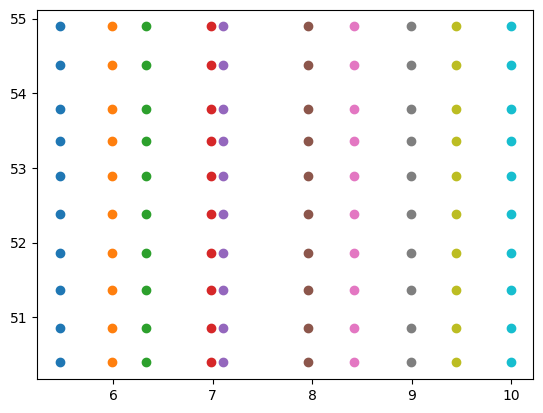

In [13]:
#Plotting subset after densification
for i in np.unique(raster):
    if i is not np.nan:
        plt.scatter(data_xr.xv[np.int64(i)], data_xr.yv[np.int64(i)])
        

Case 2: Non-sorted points

In [14]:
n_points = 400
n_time = 1

In [15]:
xx = (np.random.random(400)*(maxx - minx) + minx)
yy = (np.random.random(400)*(maxy - miny) + miny)
xxreshape = xx.reshape(n_points,1)
yyreshape = yy.reshape(n_points,1)

In [16]:
stack_xx_c2 = np.empty((n_points,0))
stack_yy_c2 = np.empty((n_points,0))

for i in range(1):
    stack_xx_c2 = np.append(stack_xx_c2, xxreshape, axis=1)
    stack_yy_c2 = np.append(stack_yy_c2, yyreshape, axis=1)

data_xr_c2 = xr.Dataset(data_vars=dict(xv=(["points","time"],stack_xx_c2),yv=(["points","time"],stack_yy_c2),),
                     coords=dict(
                        points=np.arange(n_points),
                        time=np.arange(n_time),
                        ))

data_xr_c2

<xarray.Dataset>
Dimensions:  (points: 400, time: 1)
Coordinates:
  * points   (points) int64 0 1 2 3 4 5 6 7 ... 392 393 394 395 396 397 398 399
  * time     (time) int64 0
Data variables:
    xv       (points, time) float64 5.894 8.391 9.374 ... 5.367 7.714 6.555
    yv       (points, time) float64 54.87 53.14 54.0 52.77 ... 51.59 54.14 50.39

In [17]:
df = data_xr_c2.to_dataframe().reset_index()

gdf = gpd.GeoDataFrame(
    df.index, geometry=gpd.points_from_xy(df.xv,df.yv))

grid_cell  = ((shapes) for shapes in zip(gdf.geometry, gdf.index))
raster = rasterio.features.rasterize(shapes=grid_cell, out_shape =[10,10], fill=np.NAN, all_touched= True, default_value=1, transform=affine.Affine.from_gdal(5.0, 0.5, 0.0, 54.9, 0.0, -0.5)) #, merge_alg= MergeAlg.replace
print (raster)

[[170. 395. 351.  93. 339. 389. 314. 169. 364. 378.]
 [336. 321. 355. 301. 266. 398. 263. 348. 207. 370.]
 [ 91. 385. 392. 390. 315. 358. 213. 376. 363. 372.]
 [249. 375. 296. 381. 287. 333.  15. 105. 261. 320.]
 [295. 305.  nan  73. 365. 393. 248. 316. 229. 360.]
 [396. 369. 323. 387. 255. 383. 367. 380. 319. 373.]
 [397. 262. 353. 290. 271. 202. 236. 344. 359. 329.]
 [377. 311. 180. 337. 349. 357. 219. 341. 371. 362.]
 [391. 354. 312. 165. 162. 327. 368. 382. 394. 214.]
 [ 55. 223. 379. 399. 204. 388. 343. 252. 324. 386.]]


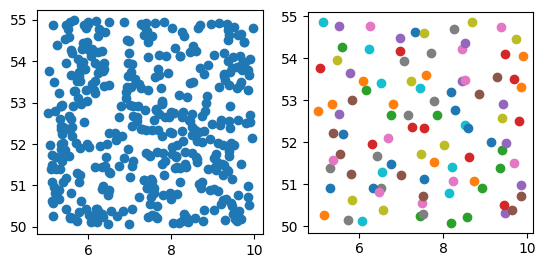

In [18]:
plt.subplot(1, 2, 1, aspect = 'equal')
plt.scatter(data_xr_c2.xv, data_xr_c2.yv) #Original complete data-set

plt.subplot(1, 2, 2, aspect = 'equal')
#Plotting subset after densification
for i in np.unique(raster):
    if not np.isnan(i):
        plt.scatter(data_xr_c2.xv[np.int64(i)], data_xr_c2.yv[np.int64(i)])

Case 3: Clustered points around 3 regions

In [19]:
n_points = 900
n_time = 1

#Defining mean for clustering around
xmeans = [5.5, 8.5, 7]
ymeans = [51, 53, 54.5]
xvar = 2
yvar = 2

xxreshape = np.empty((n_points,1))
yyreshape = np.empty((n_points,1))

xxreshape[0:300,0] = ((np.random.random(300)-0.5)*(xvar) + xmeans[0])
yyreshape[0:300,0] = ((np.random.random(300)-0.5)*(yvar) + ymeans[0])

xxreshape[300:600,0] = ((np.random.random(300)-0.5)*(xvar) + xmeans[1])
yyreshape[300:600,0] = ((np.random.random(300)-0.5)*(yvar) + ymeans[1])

xxreshape[600:900,0] = ((np.random.random(300)-0.5)*(xvar) + xmeans[2])
yyreshape[600:900,0] = ((np.random.random(300)-0.5)*(yvar) + ymeans[2])

#xxreshape = xx.reshape(n_points,1)
#yyreshape = yy.reshape(n_points,1)

In [20]:
stack_xx_c3 = np.empty((n_points,0))
stack_yy_c3 = np.empty((n_points,0))

for i in range(1):
    stack_xx_c3 = np.append(stack_xx_c3, xxreshape, axis=1)
    stack_yy_c3 = np.append(stack_yy_c3, yyreshape, axis=1)

data_xr_c3 = xr.Dataset(data_vars=dict(xv=(["points","time"],stack_xx_c3),yv=(["points","time"],stack_yy_c3),),
                     coords=dict(
                        points=np.arange(n_points),
                        time=np.arange(n_time),
                        ))

data_xr_c3

<xarray.Dataset>
Dimensions:  (points: 900, time: 1)
Coordinates:
  * points   (points) int64 0 1 2 3 4 5 6 7 ... 892 893 894 895 896 897 898 899
  * time     (time) int64 0
Data variables:
    xv       (points, time) float64 5.07 4.967 5.881 5.33 ... 6.44 6.342 7.591
    yv       (points, time) float64 50.88 50.86 51.84 ... 53.77 54.17 54.65

In [21]:
df = data_xr_c3.to_dataframe().reset_index()

gdf = gpd.GeoDataFrame(
    df.index, geometry=gpd.points_from_xy(df.xv,df.yv))

grid_cell  = ((shapes) for shapes in zip(gdf.geometry, gdf.index))
raster = rasterio.features.rasterize(shapes=grid_cell, out_shape =[10,10], fill=np.NAN, all_touched= True, default_value=1, transform=affine.Affine.from_gdal(5.0, 0.5, 0.0, 54.9, 0.0, -0.5)) #, merge_alg= MergeAlg.replace
print (raster)

[[ nan  nan 887. 891. 890. 899.  nan  nan  nan  nan]
 [ nan  nan 898. 871. 888. 865. 559. 579. 479.  nan]
 [ nan  nan 897. 893. 885. 880. 587. 599. 598.  nan]
 [ nan  nan  nan  nan  nan 583. 586. 594. 595.  nan]
 [ nan  nan  nan  nan  nan 590. 592. 597. 591.  nan]
 [235. 289. 259.  nan  nan 588. 560. 593. 571.  nan]
 [284. 294. 295.  nan  nan  nan  nan  nan  nan  nan]
 [297. 286. 272.  nan  nan  nan  nan  nan  nan  nan]
 [274. 299. 293.  nan  nan  nan  nan  nan  nan  nan]
 [270. 285. 279.  nan  nan  nan  nan  nan  nan  nan]]


(46,)


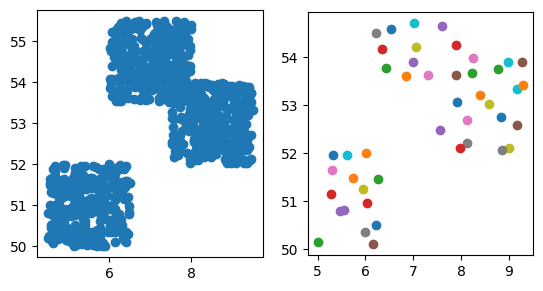

In [22]:
plt.subplot(1, 2, 1, aspect = 'equal')
plt.scatter(data_xr_c3.xv, data_xr_c3.yv) #Original complete data-set

plt.subplot(1, 2, 2, aspect = 'equal')
#Plotting subset after densification
for i in np.unique(raster):
    if not np.isnan(i):
        plt.scatter(data_xr_c3.xv[np.int64(i)], data_xr_c3.yv[np.int64(i)])

print (np.unique(raster).shape)